In [1]:
import os
import sys
import json
from pathlib import Path
sys.path.append(os.path.abspath('..'))


In [2]:
from constants import TRAIN_JSON_PATH

In [3]:

from loguru import logger
import time

from tqdm.auto import tqdm
import numpy as np
from PIL import Image  
import matplotlib.pyplot as plt

import torch
import accelerate
from torch import nn
from torch.nn import functional as F

from  torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPTextModel, CLIPTokenizer, CLIPImageProcessor, Dinov2Model

import diffusers
from diffusers import (
    PNDMScheduler, # scheduler
    UNet2DConditionModel, # unet
    AutoencoderKL, # vae
)
# ----------- local imports ----------- 
from FashionDataset import FashionDataset
from ZeroConvNet import ZeroConvNet
from constants import MODELS_SAVE_PATH
from utils import show_images, build_wandb_run
import wandb

DEBUGGING = True
model_save_directory = MODELS_SAVE_PATH / "finetune_f16_cond_as_channel_fashion_16"
model_save_directory.mkdir(exist_ok=True, parents=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("the device used", device)

generator = torch.Generator(device=device).manual_seed(42)
generator_cpu = torch.Generator(device='cpu').manual_seed(42)

# DEBUGGING
# torch.autograd.set_detect_anomaly(True)
    
dtype=torch.bfloat16

batch_size = 4
accumulation_steps = 2
num_epochs = 10
learning_rate = 1e-3
log_every = 8 # 64
save_every = 128
# small_dataset_size = 1024
small_dataset_size = 32

def _get_prompt_embeddings():
    """ get inital prompt embeddings to help model """
    # text encoder components
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype)
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype)#.to(device)

    prompt = "An ultra high-resolution, photorealistic image in 8K, A highly detailed photo, showcasing vivid colors and rich contrasts, portrait photo, perfect anatomy, 4k, high quality"
    negative_prompt = "nudity (deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime), text, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck"
        
    # Tokenize positive and negative prompts
    positive_token_ids = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt")['input_ids']#.to(device)
    negative_token_ids = tokenizer(negative_prompt, padding="max_length", truncation=True, return_tensors="pt")['input_ids']#.to(device)

    # Generate embeddings
    with torch.no_grad():
        positive_embeddings = text_encoder(positive_token_ids).last_hidden_state.type(dtype).to(device)
        negative_embeddings = text_encoder(negative_token_ids).last_hidden_state.type(dtype).to(device)

        combined_embeddings = torch.cat([negative_embeddings, positive_embeddings], dim=0)#.type(dtype)
    
    return positive_embeddings, negative_embeddings, combined_embeddings

def get_mask(image_size):
        """ generate grey mask with white for src_img and black for tar_img """
        black_ = torch.full((image_size), 0, dtype=dtype).to(device)
        white_ = torch.full(image_size, 1, dtype=dtype).to(device)
        
        return torch.cat([white_, black_], dim=1)

        

# ====================== load models ======================
model_id = "SG161222/Realistic_Vision_V6.0_B1_noVAE"

scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae", torch_dtype=dtype).to(device)
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", torch_dtype=dtype).to(device)
net = ZeroConvNet(unet, in_channels=13, out_channels=4).type(dtype).to(device)


the device used cuda


An error occurred while trying to fetch SG161222/Realistic_Vision_V6.0_B1_noVAE: SG161222/Realistic_Vision_V6.0_B1_noVAE does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch SG161222/Realistic_Vision_V6.0_B1_noVAE: SG161222/Realistic_Vision_V6.0_B1_noVAE does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [4]:
# checkpoint = torch.load("../models/finetune_f16_cond_as_channel/step_255.pth.tar")

# net.load_state_dict(checkpoint['model'])

In [5]:
# checkpoint['model']

In [6]:
from pathlib import Path
DATA_PATH = Path("../datasets/fashion", absolute=True)
MODELS_SAVE_PATH = Path("./models", absolute=True)

TRAIN_PATH = DATA_PATH / "train_lst_256_png/train_lst_256_png"    
TRAIN_POSES_PATH = DATA_PATH / "train_lst_256_png/poses"    
TRAIN_JSON_PATH = DATA_PATH / "train_data.json"

TEST_PATH = DATA_PATH / "test_lst_256_png/test_lst_256_png"    
TEST_JSON_PATH = DATA_PATH / "train_data.json"
TRAIN_PATH.exists()


/tmp/ipykernel_9099/1429964568.py:2: DeprecationWarning: support for supplying keyword arguments to pathlib.PurePath is deprecated and scheduled for removal in Python 3.14
  DATA_PATH = Path("../datasets/fashion", absolute=True)
/tmp/ipykernel_9099/1429964568.py:3: DeprecationWarning: support for supplying keyword arguments to pathlib.PurePath is deprecated and scheduled for removal in Python 3.14
  MODELS_SAVE_PATH = Path("./models", absolute=True)


True

In [7]:
positive_embeddings, negative_embeddings, combined_embeddings = _get_prompt_embeddings()
embeddings = positive_embeddings.repeat(batch_size, 1, 1)

train_dataset = FashionDataset(root_dir = TRAIN_PATH, 
                 poses_dir = TRAIN_POSES_PATH,
                 info_json_path = TRAIN_JSON_PATH,
                 small_dataset_size=small_dataset_size)
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, generator=generator_cpu
)

# Define the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
loss_fn = nn.MSELoss()

optimizer.zero_grad()

mask = get_mask((256 // 8, 352 // 16)).unsqueeze(0).unsqueeze(0) #[white, black]
mask = mask.expand(batch_size, -1, -1, -1)

In [8]:
inputs = next(iter(train_dataloader))

In [9]:
src_mask = inputs['src_mask'].type(dtype).to(device)
st_pose = inputs['st_pose'].type(dtype).to(device)
src_tar = inputs['src_tar'].type(dtype).to(device)

In [10]:
with torch.no_grad():
    # masked_latents
    src_mask_latents = vae.encode(src_mask).latent_dist.sample() * 0.18215
    # latents 
    src_tar_latents = vae.encode(src_tar).latent_dist.sample() * 0.18215 
    
    st_pose_latents = vae.encode(st_pose).latent_dist.sample() * 0.18215 

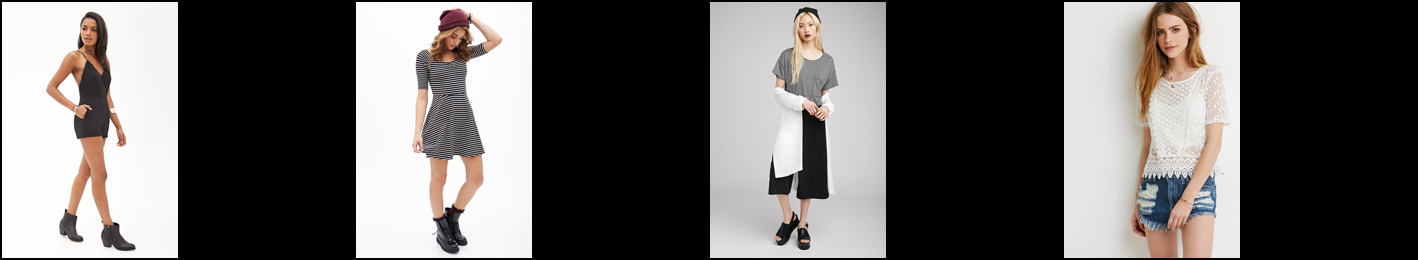

In [12]:
show_images(src_mask.type(torch.float32))

In [13]:
scheduler.set_timesteps(50)
latents = torch.randn((batch_size, unet.config.in_channels, 256 // 8, 352 // 8), generator=generator, device=device, dtype=dtype)

for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    latent_model_input = torch.cat([latents, src_mask_latents, mask, st_pose_latents], dim=1)
    with torch.no_grad():
        noise_pred = net(latent_model_input, t, encoder_hidden_states=embeddings).sample
    latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    
latents = (1 / 0.18215 * latents).clamp(-1, 1)
with torch.no_grad():
    outputs = vae.decode(latents).sample

  0%|          | 0/51 [00:00<?, ?it/s]

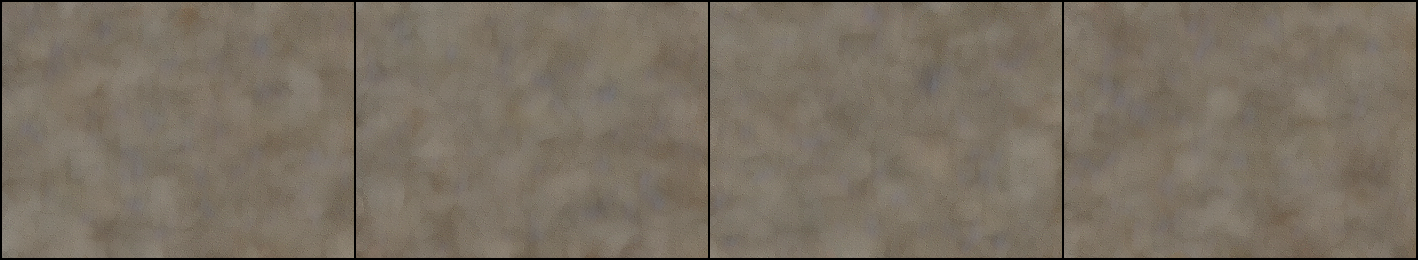

In [14]:
show_images(outputs.type(torch.float32))